In [26]:
import sys
sys.path.append("../../")
import datasets
from src.models.components.partmae_v5 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b
from src.data.components.transforms.multi_crop_v3 import ParametrizedMultiCropV3
from src.data.components.transforms.multi_crop_v2 import ParametrizedMultiCropV2
from src.models.components.metrics.partmae_v3 import V3Metrics
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import math
import timm
import timm.scheduler
import torch.optim
import torch.utils._pytree as pytree
from src.utils.visualization.reconstruction_v5_anchor_reparam import reconstruction_lstsq_with_anchor_reparam
from src.utils.visualization.reconstruction_v5_gt import reconstruction_gt
from omegaconf import OmegaConf
import hydra

## Utils

In [27]:
def clean_model_io(batch: tuple, out: dict, device="cuda"):
    """
    Clean and organize model inputs and outputs for visualization and analysis.
    
    Args:
        batch: A tuple containing model inputs (global images, global params, local images, local params)
        out: Model output dictionary
        device: Device to move tensors to (default: "cuda")
        
    Returns:
        io: Dictionary containing organized model inputs and outputs
    """
    # Initialize output dictionary
    io = dict()
    
    # Extract shapes from model output
    g_crop_size, gN, gV = out["shapes"][0]  # global crop size, tokens per crop, number of crops
    l_crop_size, lN, lV = out["shapes"][1]  # local crop size, tokens per crop, number of crops
    
    # Extract and organize inputs
    io["x"] = [[*gxs, *lxs] for gxs, lxs in zip(batch[0], batch[2])]
    io["canonical_params"] = batch[1][:, 0, :4]
    io["params"] = [[*gp, *lp] for gp, lp in zip(batch[1], batch[3])]
    io["crop_params"] = [[param[4:8] for param in batch_params] for batch_params in io["params"]]
    io["crop_sizes"] = [*[g_crop_size for _ in range(gV)], *[l_crop_size for _ in range(lV)]]
    io["num_tokens"] = [*[gN for _ in range(gV)], *[lN for _ in range(lV)]]
    
    # Include all output values
    io.update({name: out[name] for name in out.keys()})
    
    # Move all tensors to the specified device
    io = pytree.tree_map_only(
        Tensor,
        lambda t: t.detach().to(device),
        io
    )
    
    return io


In [28]:

def make_plots(
    model,
    io,
    train_transform,
    original_img,
):
    gt_reconstruction = reconstruction_gt(
        x=io["x"][0],
        patch_positions_nopos=io["patch_positions_nopos"][0],
        num_tokens=io["num_tokens"],
        crop_params=io["crop_params"][0],
        patch_size=model.patch_size,
        canonical_img_size=model.canonical_img_size,
    )
    pred_reconstruction, *_ = reconstruction_lstsq_with_anchor_reparam(
        x=io["x"][0],
        patch_positions_nopos=io["patch_positions_nopos"][0],
        num_tokens=io["num_tokens"],
        crop_params=io["crop_params"][0],
        patch_size=model.patch_size,
        canonical_img_size=model.canonical_img_size,
        max_scale_ratio=model.max_scale_ratio,
        pred_dT=io["pred_dT"][0],
    )
    fig, axes = plt.subplots(1, 3)
    canonical_img = train_transform.recreate_canonical(
        original_img, io["canonical_params"][0]
    )
    axes[0].imshow(canonical_img)
    axes[0].set_title("Original")
    axes[1].imshow(gt_reconstruction.permute(1, 2, 0).cpu())
    axes[1].set_title("GT reconstruction")
    axes[2].imshow(pred_reconstruction.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstruction")
    return fig, axes

## Reconstruction

In [35]:
img = Image.open("../../artifacts/samoyed.jpg").crop((0, 0, 1000, 1000))
gV = 2
lV = 1
train_transform = ParametrizedMultiCropV3(n_global_crops=gV, n_local_crops=lV)
batch = train_transform(img)
batch = default_collate([batch])

In [36]:
# overfit to a few batches
torch.set_float32_matmul_precision("high")

In [37]:
RUN_ID = "nw6nhpa2"
EPOCH = "0199"

In [38]:
cfg = OmegaConf.load(f"../../artifacts/model-{RUN_ID}:v0/config.yaml")

In [39]:
fabric = Fabric()
state = {
    "model": hydra.utils.instantiate(cfg["model"], _target_="src.models.components.partmae_v5_2.PARTMaskedAutoEncoderViT" ,verbose=True)
}
ckpt = fabric.load(f"../../artifacts/model-{RUN_ID}:v0/epoch_{EPOCH}.ckpt", state)
model = state["model"]
print(ckpt.keys())
print(ckpt["epoch"])

dict_keys(['optimizer', 'epoch', 'global_step', 'scheduler'])
199


In [40]:
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out, 'cuda')
fig, axes = make_plots(
    model,
    io,
    train_transform,
    img,
)

IndexError: list index out of range

/tmp/ipykernel_2718/504563146.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', num_points)


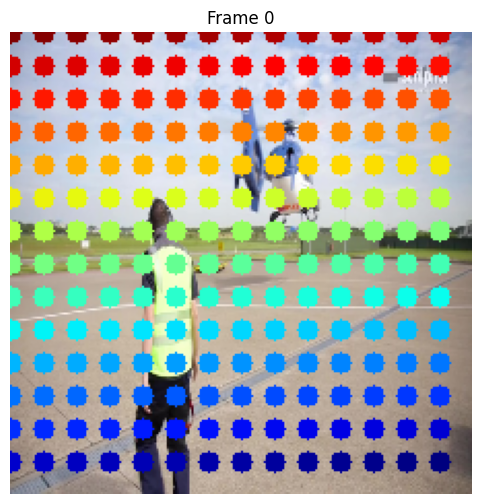

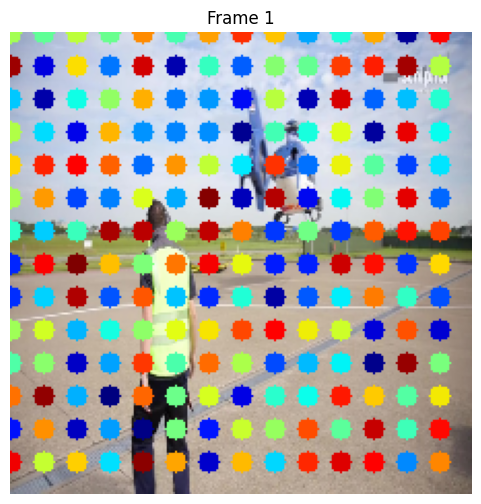

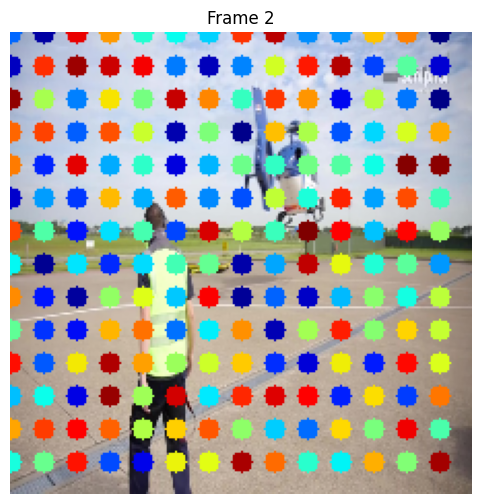

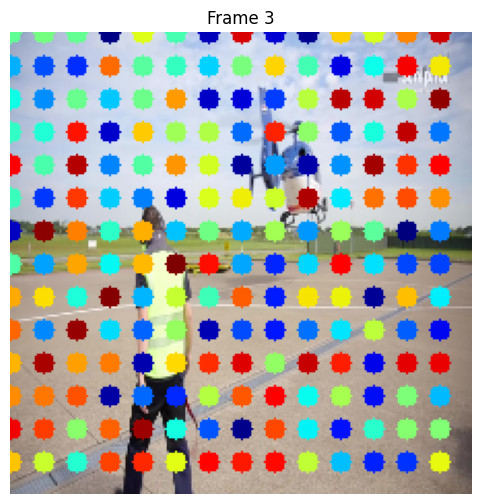

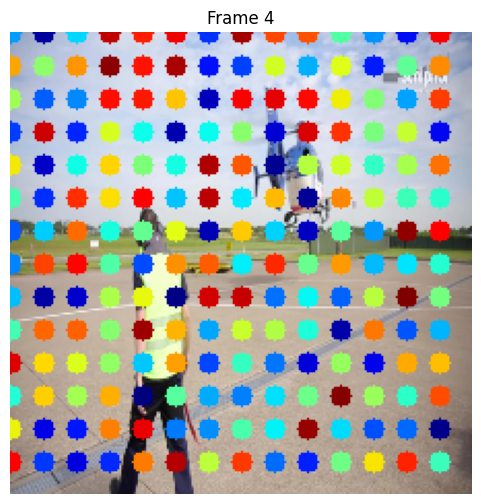

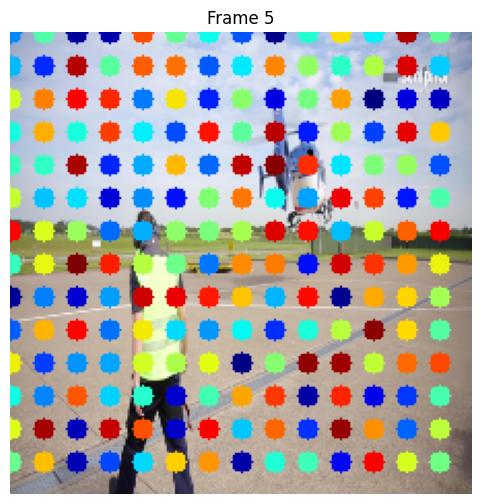

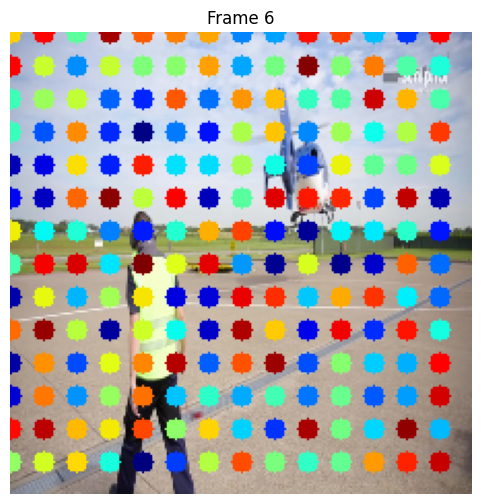

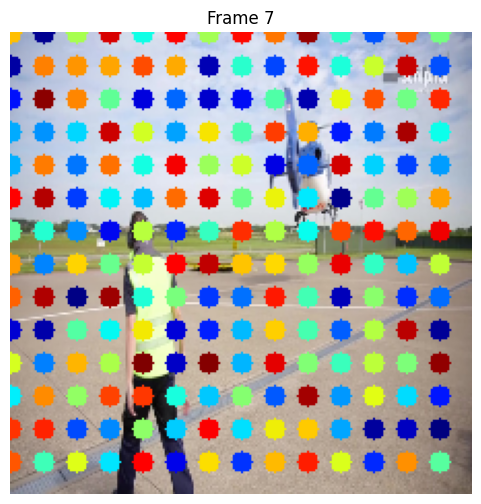

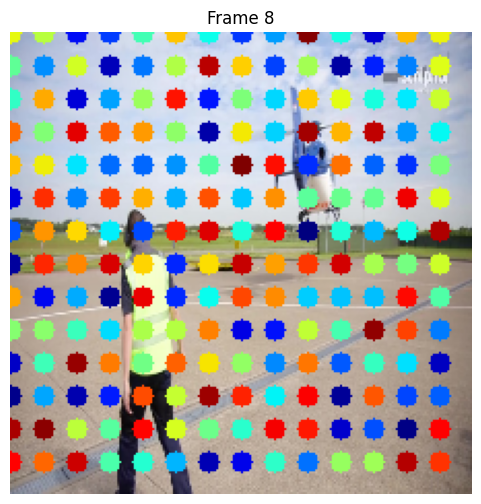

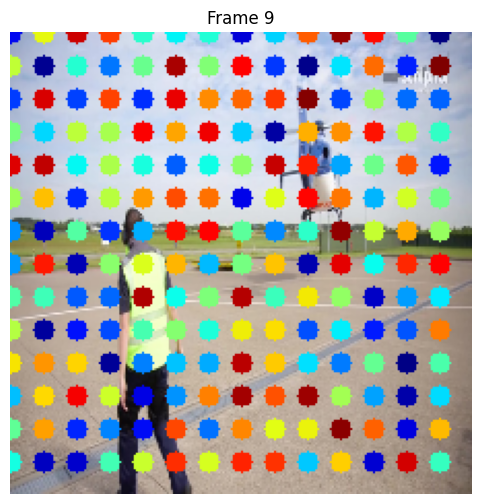

In [51]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
from scipy.optimize import linear_sum_assignment

# --- Helper: Matching between points using Hungarian assignment ---
def match_patches(pred_dT: torch.Tensor, num_points: int):
    """
    Computes a one-to-one mapping from points in frame A (first num_points)
    to points in frame B (remaining points) by solving a Hungarian matching problem.
    
    Args:
        pred_dT (torch.Tensor): Tensor of shape [B, T, T, 4] with predicted relative differences.
                                Here T = num_points (frame A) + num_points (frame B).
        num_points (int): Number of points (patches) per frame.
        
    Returns:
        A list (length B) of tuples (row_indices, col_indices) for the assignment.
        row_indices are indices in frame A and col_indices are corresponding indices in frame B.
    """
    assignments = []
    B = pred_dT.shape[0]
    for b in range(B):
        # Use only the translation components (dx, dy; first two dimensions)
        cost_matrix = torch.norm(pred_dT[b, :num_points, num_points:, :2], dim=-1)
        cost_np = cost_matrix.cpu().detach().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_np)
        assignments.append((row_ind, col_ind))
    return assignments

# --- New function: Visualize tracking using model-derived patch positions ---
def visualize_tracking_points_with_model_positions(video_frames, model, device='cpu', dot_radius=5):
    """
    Performs TAPIR/DINO-style frame-by-frame tracking using keypoints obtained
    from the model's patch embedding. For the first frame, we extract patch positions
    via the patch_embed. Then for each subsequent frame pair we run the full forward pass
    to obtain:
      - "pred_dT": the predicted pairwise differences (used for matching), and
      - "patch_positions_nopos": the joint patch positions for frame A and frame B.
    
    Colors assigned to keypoints are propagated from frame to frame based on the matching.
    Finally, the points are drawn on each frame.
    
    Args:
        video_frames (list): List of frames as BGR numpy arrays.
        model: Pretrained SSL model (expects to output a dict with keys "pred_dT" and "patch_positions_nopos").
        device (str): Device on which to run the model.
        dot_radius (int): Radius of the circle to draw at each keypoint.
    """
    transform = T.Compose([T.ToTensor()])
    
    # --- For the first frame: obtain patch positions from the model's patch_embed ---
    frame0 = video_frames[0]
    tensor0 = transform(cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        # The patch_embed returns (embedded tokens, patch_positions_vis)
        _, patch_positions_vis = model.patch_embed(tensor0)
    # patch_positions_vis: shape [B, N, 2] for visible patches.
    points0 = patch_positions_vis[0].cpu().numpy()  # shape [N, 2]
    num_points = points0.shape[0]
    
    # Initialize colors for each keypoint using a colormap.
    cmap = plt.cm.get_cmap('jet', num_points)
    init_colors = {i: (np.array(cmap(i)[:3]) * 255).astype(np.uint8) for i in range(num_points)}
    
    tracked_colors = [init_colors.copy()]
    current_colors = init_colors.copy()
    points_list = [points0]  # list of keypoint arrays for each frame

    # Now process each consecutive pair of frames.
    for idx in range(len(video_frames) - 1):
        frame_A = video_frames[idx]
        frame_B = video_frames[idx+1]
        
        tensor_A = transform(cv2.cvtColor(frame_A, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)
        tensor_B = transform(cv2.cvtColor(frame_B, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)
        
        # Prepare dummy crop parameters.
        H, W = frame_A.shape[:2]
        # Create dummy crop parameters: here we assume a full-image crop.
        dummy_params = torch.tensor([[[0, 0, 0, 0, 0, 0, H, W]]], dtype=torch.float32, device=device)
        
        # Pack frames as expected: shape [B, V, C, H, W]. Using one view per frame.
        g_x = tensor_A.unsqueeze(1)  # shape: [1, 1, C, H, W]
        l_x = tensor_B.unsqueeze(1)  # shape: [1, 1, C, H, W]
        
        with torch.no_grad():
            out = model(g_x, dummy_params, l_x, dummy_params)
        # out should contain "pred_dT" of shape [B, T, T, 4] and "patch_positions_nopos" of shape [B, T, 2],
        # where T = num_points (frame A) + num_points (frame B).
        pred_dT = out["pred_dT"]
        joint_points = out["patch_positions_nopos"][0].cpu().numpy()  # shape [T, 2]
        
        points_A = joint_points[:num_points]   # keypoints for frame A
        points_B = joint_points[num_points:]   # keypoints for frame B
        
        # For matching, use Hungarian assignment on pred_dT.
        assignment = match_patches(pred_dT, num_points)
        row_ind, col_ind = assignment[0]
        
        # Propagate colors: assign each keypoint in frame B the color of its match from frame A.
        new_colors = {}
        for i, j in zip(row_ind, col_ind):
            new_colors[j] = current_colors[i]
        # For any unmatched keypoint, assign a random color.
        for j in range(num_points):
            if j not in new_colors:
                new_colors[j] = np.random.randint(0, 255, 3)
        current_colors = new_colors
        tracked_colors.append(current_colors.copy())
        points_list.append(points_B)
    
    # --- Visualization: Draw colored dots on each frame using the model's patch positions ---
    output_frames = []
    for f_idx, frame in enumerate(video_frames):
        frame_vis = frame.copy()
        colors_map = tracked_colors[f_idx]
        pts = points_list[f_idx]
        # Here we assume that the points are in (y, x) coordinates.
        for i, (p0, p1) in enumerate(pts):
            # Depending on your model, the order may be (x, y). Adjust if needed.
            cy, cx = int(p0), int(p1)
            color = tuple(int(c) for c in colors_map[i])
            cv2.circle(frame_vis, (cx, cy), dot_radius, color, -1)
        output_frames.append(frame_vis)
    
    # Display the frames.
    for idx, frame in enumerate(output_frames):
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {idx}")
        plt.axis("off")
        plt.show()




# --- Example usage ---
if __name__ == "__main__":
    # Load video frames from a video file using OpenCV (or substitute with your list of frames)
    # open folder 
    from pathlib import Path
    images_path = Path("../../artifacts/helicopter")
    model.update_conf(mask_ratio=0, pos_mask_ratio=1, sampler='ongrid_canonical')
    # images in folder are 00000.jpg, 00001.jpg, ...
    video_frames = []
    # retrieve all jpg files in the folder, order them by name, and load them
    for img_path in sorted(images_path.glob("*.jpg")):
        frame = cv2.imread(str(img_path))
        # resize to 224x224
        frame = cv2.resize(frame, (224, 224))
        video_frames.append(frame)
    # get first 10
    video_frames = video_frames[:10]

    device='cpu' 
    if len(video_frames) == 0:
        print("No frames loaded. Please check the video file path.")
    else:
        # Run visualization with a chosen patch size (e.g., 16)
        visualize_tracking_points_with_model_positions(video_frames, model=model, device=device, dot_radius=5)